# Canadian Rental Prices Exploratory Data Analysis

## Introduction

The dataset analysed in this notebook is called *25000+ Canadian rental housing market June 2024*. It can be found [here](https://www.kaggle.com/datasets/sergiygavrylov/25000-canadian-rental-housing-market-june-2024). This notebook presents insights into the various factors that can influence rental prices all across Canada.

In [21]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Helper functions

In [23]:
def q1(x):
    return x.quantile(0.25)

In [24]:
def q3(x):
    return x.quantile(0.75)

In [25]:
def get_zip_code(row):
    location = reverse((row['latitude'], row['longitude']), language='en', exactly_one=True)
    keys = location.raw['address'].keys()
    if 'postcode' in keys :
        print(location.raw['address']['postcode'])
        return location.raw['address']['postcode'][:3]# Only keep the first three letters
    else:
        return None

---

## 1. Data Exploration

In [28]:
# Load data
df = pd.read_csv('Data/canada_rent.csv')
df.shape

(25771, 18)

In [29]:
df.sample(5)

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
11817,565761,Calgary,Alberta,7804 Hunterview Drive Northwest,51.122407,-114.084774,Long Term,Townhouse,2350.0,3 Beds,2,NaN,/ab/calgary/rentals/townhouse/3-bedrooms/hunti...,Unfurnished,Immediate,Non-Smoking,True,True
2429,82606,Calgary,Alberta,1107 17 Avenue S.W.,51.037684,-114.087556,Long Term,Apartment,2100.0,1 Bed,1.5,1034,/ab/calgary/rentals/apartment/1-bedroom/downto...,Unfurnished,Immediate,Non-Smoking,False,False
19301,331044,Owen Sound,Ontario,575 28th St. W.,44.592507,-80.949008,Long Term,Apartment,2000.0,3 Beds,1,1011,/on/owen-sound/rentals/apartment/3-bedrooms/pe...,Unfurnished,Immediate,Non-Smoking,True,True
8338,334177,Lethbridge,Alberta,175 Algonquin Road,49.685137,-112.883942,Long Term,Apartment,1505.0,2 Beds,1,750,/ab/lethbridge/rentals/apartment/2-bedrooms/ri...,Unfurnished,Immediate,Non-Smoking,True,True
14134,47994,Calgary,Alberta,"#104, 224 - 90th Avenue SE",50.972543,-114.066826,Long Term,Apartment,1350.0,Studio,1,550,/ab/calgary/rentals/apartment/1-bedroom/acadia...,Unfurnished,No Vacancy,Non-Smoking,False,False


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15  smoking            23069 non-null  object 
 16  cats               255

In [31]:
df.describe()

,rentfaster_id,latitude,longitude,price
count,25771.000000,25771.000000,25771.000000,25771.000000
mean,471913.795274,48.903370,-100.332196,2151.624142
std,120330.335865,3.603257,17.917001,972.820941
min,820.000000,40.741802,-128.661880,0.000000
25%,415749.000000,45.418785,-114.074660,1600.000000
50%,522379.000000,50.913739,-113.513905,2045.000000
75%,563397.500000,51.093585,-79.401311,2550.000000
max,572635.000000,62.459246,-52.695472,29990.000000


In [32]:
df.isnull().sum()

rentfaster_id           0
city                    0
province                0
address               125
latitude                0
longitude               0
lease_term             46
type                    0
price                   0
beds                  132
baths                 134
sq_feet              4112
link                    0
furnishing              0
availability_date      12
smoking              2702
cats                  173
dogs                  173
dtype: int64

In [33]:
len(df[df.duplicated()])

6726

---

## 2. Data Preparation

### 2.1 Remove unnecessary rows

In [37]:
# Drop dows when price is 0
df = df[df['price'] > 0]

In [ ]:
# Drop duplicates
df.drop_duplicates(keep='first', inplace=True)
df = df.reset_index(drop=True)

There still are a lot of rows with the same Rentfaster ID but with different prices and square feets. Based on the website, it seems to be multiple units in the same building.

In [39]:
# Example of a townhouse with multiple units
df[df['rentfaster_id'] == 468622]

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,2.5,1180,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2095.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,November 18,Non-Smoking,True,True
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1351,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True


### 2.2 Convert some string columns into categorical columns

In [41]:
# Check unique values
display(df['province'].unique())
display(df['lease_term'].unique())
display(df['type'].unique())
display(df['furnishing'].unique())
display(df['smoking'].unique())

array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia',
       'Northwest Territories', 'Ontario', 'Quebec', 'Saskatchewan'],
      dtype=object)

array(['Long Term', 'Negotiable', 'Short Term', '12 months', 'months',
       '6 months', nan], dtype=object)

array(['Townhouse', 'Apartment', 'Main Floor', 'House', 'Basement',
       'Duplex', 'Storage', 'Condo Unit', 'Room For Rent', 'Loft',
       'Acreage', 'Office Space', 'Parking Spot', 'Vacation Home',
       'Mobile'], dtype=object)

array(['Unfurnished', 'Furnished', 'Negotiable',
       'Unfurnished, Negotiable'], dtype=object)

array(['Non-Smoking', 'Smoke Free Building', nan, 'Negotiable',
       'Smoking Allowed'], dtype=object)

In [43]:
df[['province', 'lease_term', 'type', 'furnishing', 'smoking']].nunique()

province      10
lease_term     6
type          15
furnishing     4
smoking        4
dtype: int64

In [26]:
# Fill null values
df['lease_term'] = df['lease_term'].fillna('Unknown')
df['smoking'] = df['smoking'].fillna('Unknown')

In [27]:
df['furnishing'].value_counts()

furnishing
Unfurnished                17325
Furnished                   1376
Negotiable                   243
Unfurnished, Negotiable        3
Name: count, dtype: int64

In [28]:
# Merge 'Negotiable' and 'Unfurnished, Negotiable'
df['furnishing'] = df['furnishing'].str.replace('Unfurnished, Negotiable', 'Negotiable')
df['furnishing'].value_counts()

furnishing
Unfurnished    17325
Furnished       1376
Negotiable       246
Name: count, dtype: int64

In [29]:
# Make sure there are no null values
assert df['province'].isnull().sum() == 0
assert df['lease_term'].isna().sum() == 0
assert df['type'].isna().sum() == 0
assert df['furnishing'].isna().sum() == 0
assert df['smoking'].isna().sum() == 0

In [30]:
# Convert data
df[['province', 'lease_term', 'type', 'furnishing', 'smoking']] = \
    df[['province', 'lease_term', 'type', 'furnishing', 'smoking']].astype('category')

In [31]:
# Display descriptions
df[['province', 'lease_term', 'type', 'furnishing', 'smoking']].describe()

,province,lease_term,type,furnishing,smoking
count,18947,18947,18947,18947,18947
unique,10,7,15,3,5
top,Alberta,Long Term,Apartment,Unfurnished,Non-Smoking
freq,8321,17726,13229,17325,16147


In [32]:
# Print the number of unique values for the rest of the string columns
df[['city', 'address', 'link', 'availability_date']].nunique()

city                  269
address              8002
link                 9615
availability_date     132
dtype: int64

The string columns mentionned in the previous cell won't be categorized, as they contain too many unique values.

### 2.3 Convert some string columns into numerical columns

In [35]:
# Check unique values of beds
df['beds'].unique()

array(['2 Beds', '3 Beds', 'Studio', '1 Bed', '5 Beds', '4 Beds', nan,
       '6 Beds', 'none Beds', '8 Beds', '7 Beds', '9 Beds'], dtype=object)

In [36]:
# Remove 'Bed(s)' from values
df['beds'] = df['beds'].str.strip('Beds')

# Replace none and Studio by 0
df['beds'] = df['beds'].str.replace('none', '0')
df['beds'] = df['beds'].str.replace('Studio', '0')

# Fill null values by zero
df['beds'] = df['beds'].fillna('0')
assert df['beds'].isna().sum() == 0

In [37]:
# Convert beds to integer
df['beds'] = df['beds'].astype('int')
df['beds'].unique()

array([2, 3, 0, 1, 5, 4, 6, 8, 7, 9])

In [38]:
# Check unique values of baths
df['baths'].unique()

array(['2.5', '1', '2', '1.5', '3.5', nan, '4', '3', '5', 'none', '4.5',
       '7.5', '5.5', '6', '6.5', '7', '8', '0'], dtype=object)

In [39]:
# Replace none by 0
df['baths'] = df['baths'].replace('none', '0')

# Fill null values by 0
df['baths'] = df['baths'].fillna('0')
assert df['baths'].isna().sum() == 0

In [40]:
# Make sure there are no null values
assert df['baths'].isna().sum() == 0

In [41]:
# Convert data to float
df['baths'] = df['baths'].astype('float')
df['baths'].unique()

array([2.5, 1. , 2. , 1.5, 3.5, 0. , 4. , 3. , 5. , 4.5, 7.5, 5.5, 6. ,
       6.5, 7. , 8. ])

In [42]:
# Check the proportion of rows with null square feets
nb_null = df['sq_feet'].isna().sum()
all_rows = len(df['sq_feet'])
null_values_ratio = nb_null / all_rows
null_values_ratio

0.15395577136222094

If all the rows with null square feets are deleted, 15.4% of our data will be lost. A better option would be to fill the missing values with the mean of each type of rental for each city.

In [44]:
# Remove strings from values and convert sq_feet column to float
df['sq_feet'] = df['sq_feet'].str.replace(',', '')
df['sq_feet'] = df['sq_feet'].str.extract(r'(\d+[.\d]*)')
df['sq_feet'] = df['sq_feet'].astype('float')

In [45]:
# Fill missing values with mean
df['sq_feet'] = df['sq_feet'].fillna(df.groupby(['province', 'city', 'type'], observed=True)['sq_feet'].transform('mean').iloc[0])
assert df['sq_feet'].isnull().sum() == 0

In [46]:
# Display descriptions
df[['beds', 'baths', 'sq_feet']].describe()

,beds,baths,sq_feet
count,18947.000000,18947.000000,18947.000000
mean,1.695150,1.375521,947.477174
std,0.968336,0.632467,486.391503
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,635.000000
50%,2.000000,1.000000,870.000000
75%,2.000000,2.000000,1300.000000
max,9.000000,8.000000,11700.000000


### 2.4 Convert some strings columns into boolean columns

In [48]:
# Check unique values
display(df['cats'].unique())
display(df['dogs'].unique())

array([True, False, nan], dtype=object)

array([True, False, nan], dtype=object)

In [49]:
# To make things simpler, the null values will be set at false
df['cats'] = df['cats'].fillna('False')
df['dogs'] = df['dogs'].fillna('False')
assert df['cats'].isna().sum() == 0
assert df['dogs'].isna().sum() == 0

In [50]:
# Convert data
df[['cats', 'dogs']] = df[['cats', 'dogs']].astype('bool')

In [51]:
# Display descriptions
df[['cats', 'dogs']].describe()

,cats,dogs
count,18947,18947
unique,2,2
top,True,True
freq,12919,12371


### Summary

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18947 entries, 0 to 18946
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   rentfaster_id      18947 non-null  int64   
 1   city               18947 non-null  object  
 2   province           18947 non-null  category
 3   address            18822 non-null  object  
 4   latitude           18947 non-null  float64 
 5   longitude          18947 non-null  float64 
 6   lease_term         18947 non-null  category
 7   type               18947 non-null  category
 8   price              18947 non-null  float64 
 9   beds               18947 non-null  int64   
 10  baths              18947 non-null  float64 
 11  sq_feet            18947 non-null  float64 
 12  link               18947 non-null  object  
 13  furnishing         18947 non-null  category
 14  availability_date  18939 non-null  object  
 15  smoking            18947 non-null  category
 16  cats

---

## 3. Data Visualization

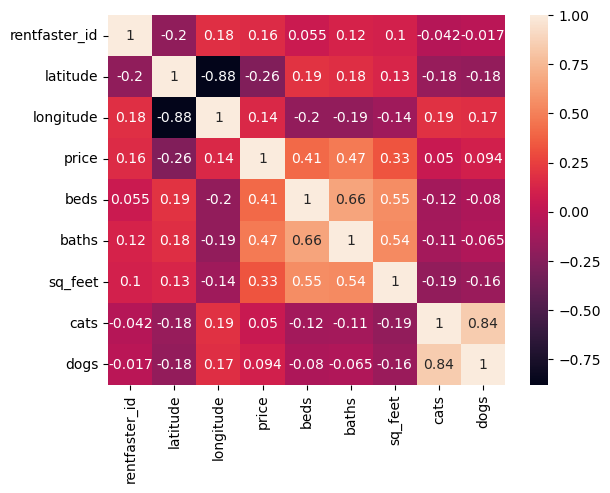

In [56]:
# Correlation between numeric values
sns.heatmap(df.corr(numeric_only=True), annot=True);

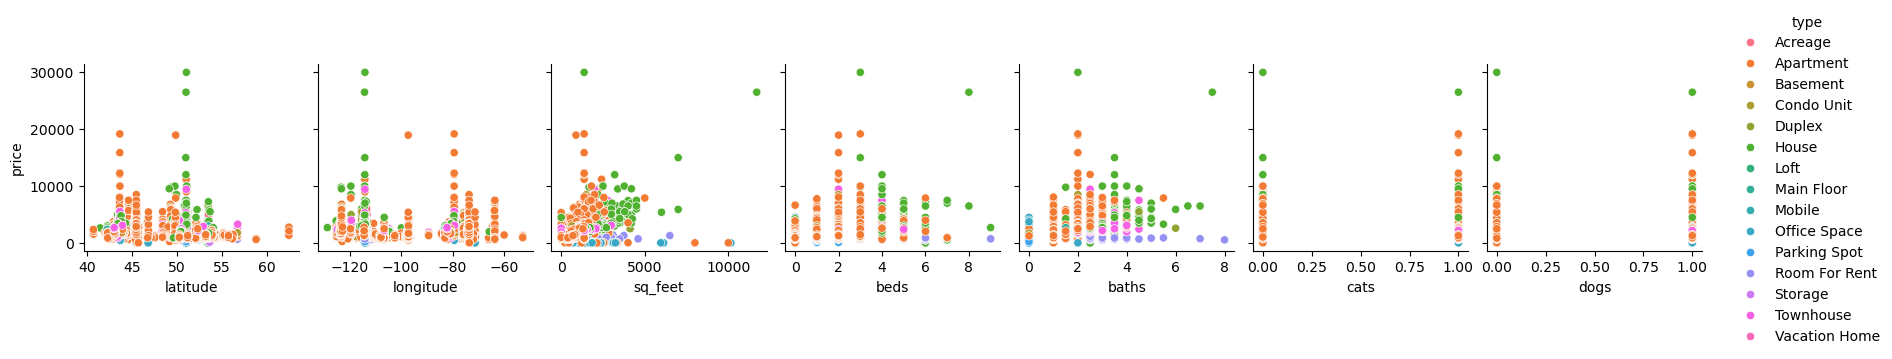

In [57]:
# Correlation of the numeric values with the price
sns.pairplot(df, x_vars=['latitude', 'longitude', 'sq_feet', 'beds', 'baths', 'cats', 'dogs'], y_vars=['price'], hue='type');

The price seems to be somewhat correlated with the square feet (0.33), the number of bedrooms (0.41) and the number of bathrooms (0.47). Also, the rentals where animals are not accepted seem to be more expensive. The most expensive rentals are houses.

In [59]:
# Filter Quebec data
quebec = df[df['province'] == 'Quebec']
quebec.shape

(2091, 18)

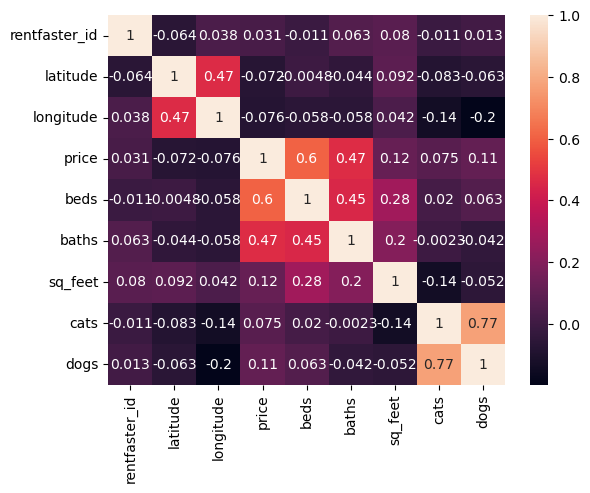

In [60]:
# Correlation between numerical values of Quebec data
sns.heatmap(quebec.corr(numeric_only=True), annot=True);

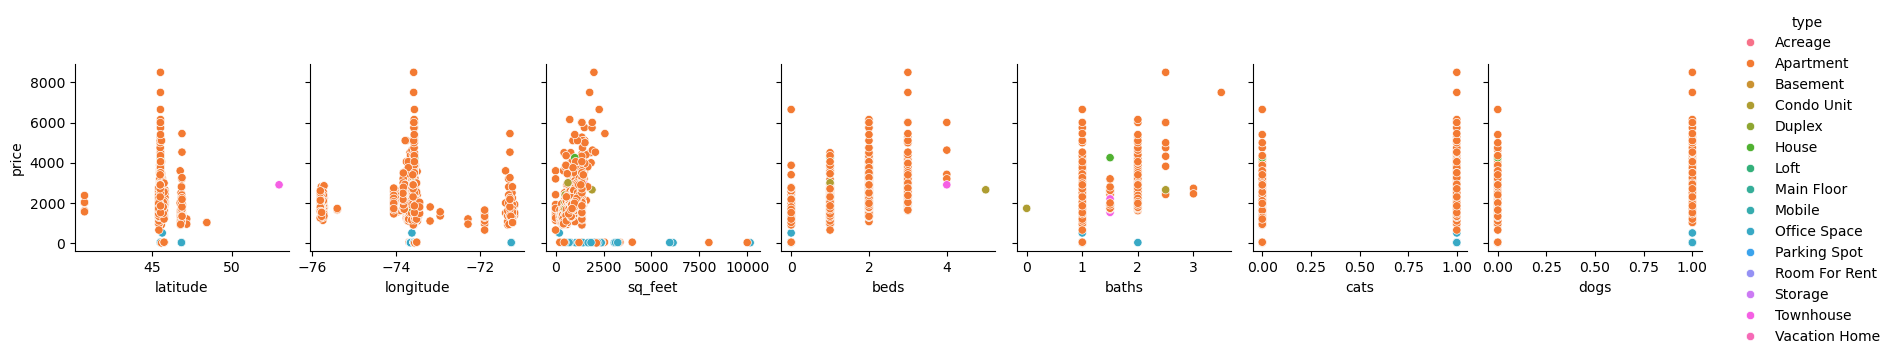

In [61]:
# Correlation of the numeric values with the price in Quebec
sns.pairplot(quebec, x_vars=['latitude', 'longitude', 'sq_feet', 'beds', 'baths', 'cats', 'dogs'], y_vars=['price'], hue='type');

The correlation between the price and the square feet is much weaker (0.12). The correlation with the number of bedrooms is stronger (0.6) whereas the correlation with the number of bathrooms is the same (0.47). It's interesting to see that the rentals where animals are accepted seem to be more expensive, whereas it's cheaper all over the country. Also, most rentals in Quebec are apartments. It shows that analyzing data all across the country is not enough.

In [63]:
# Filter Montreal data
montreal = quebec[quebec['city'] == 'Montréal']
montreal.shape

(1514, 18)

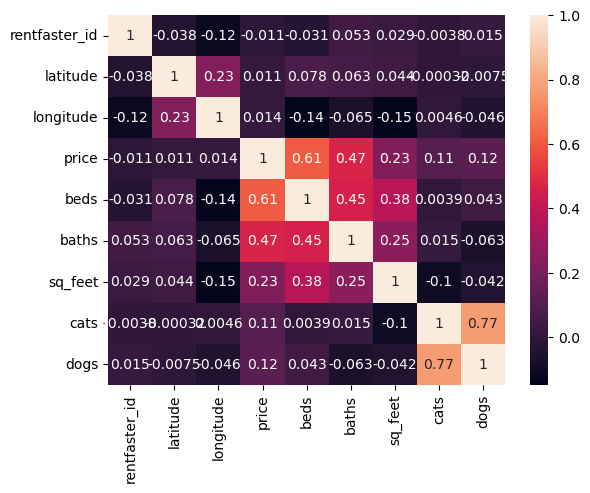

In [64]:
sns.heatmap(montreal.corr(numeric_only=True), annot=True);

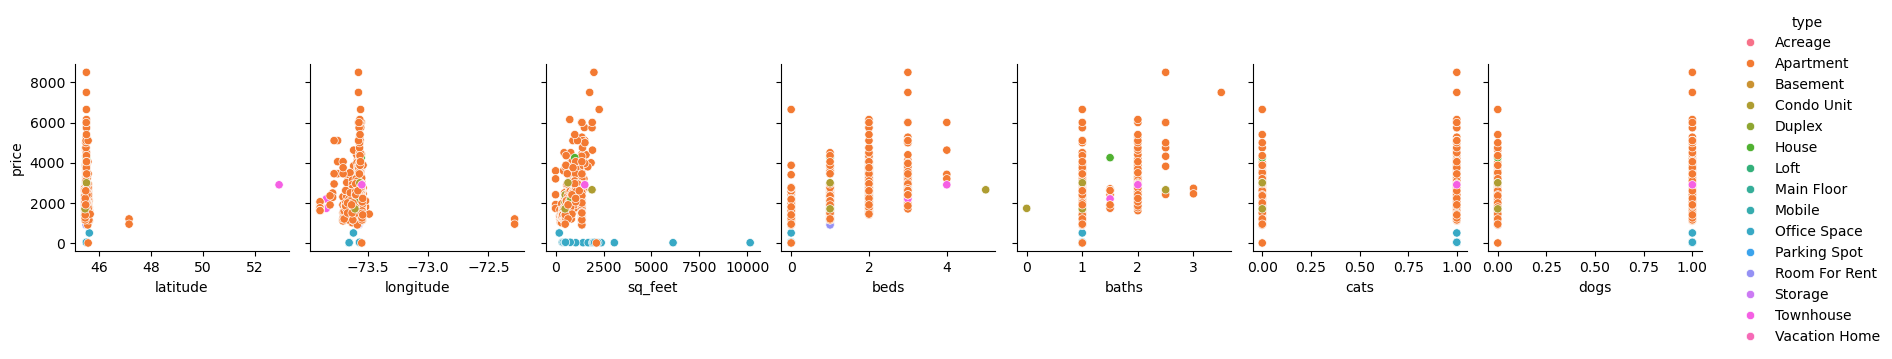

In [65]:
sns.pairplot(montreal, x_vars=['latitude', 'longitude', 'sq_feet', 'beds', 'baths', 'cats', 'dogs'], y_vars=['price'], hue='type');

The correlation between the price and the square feet is a bit stronger than the one for Quebec (0.23). The other numbers are almost the same (0.43 and 0.23), probably because most of the Quebec ads are from Montreal.

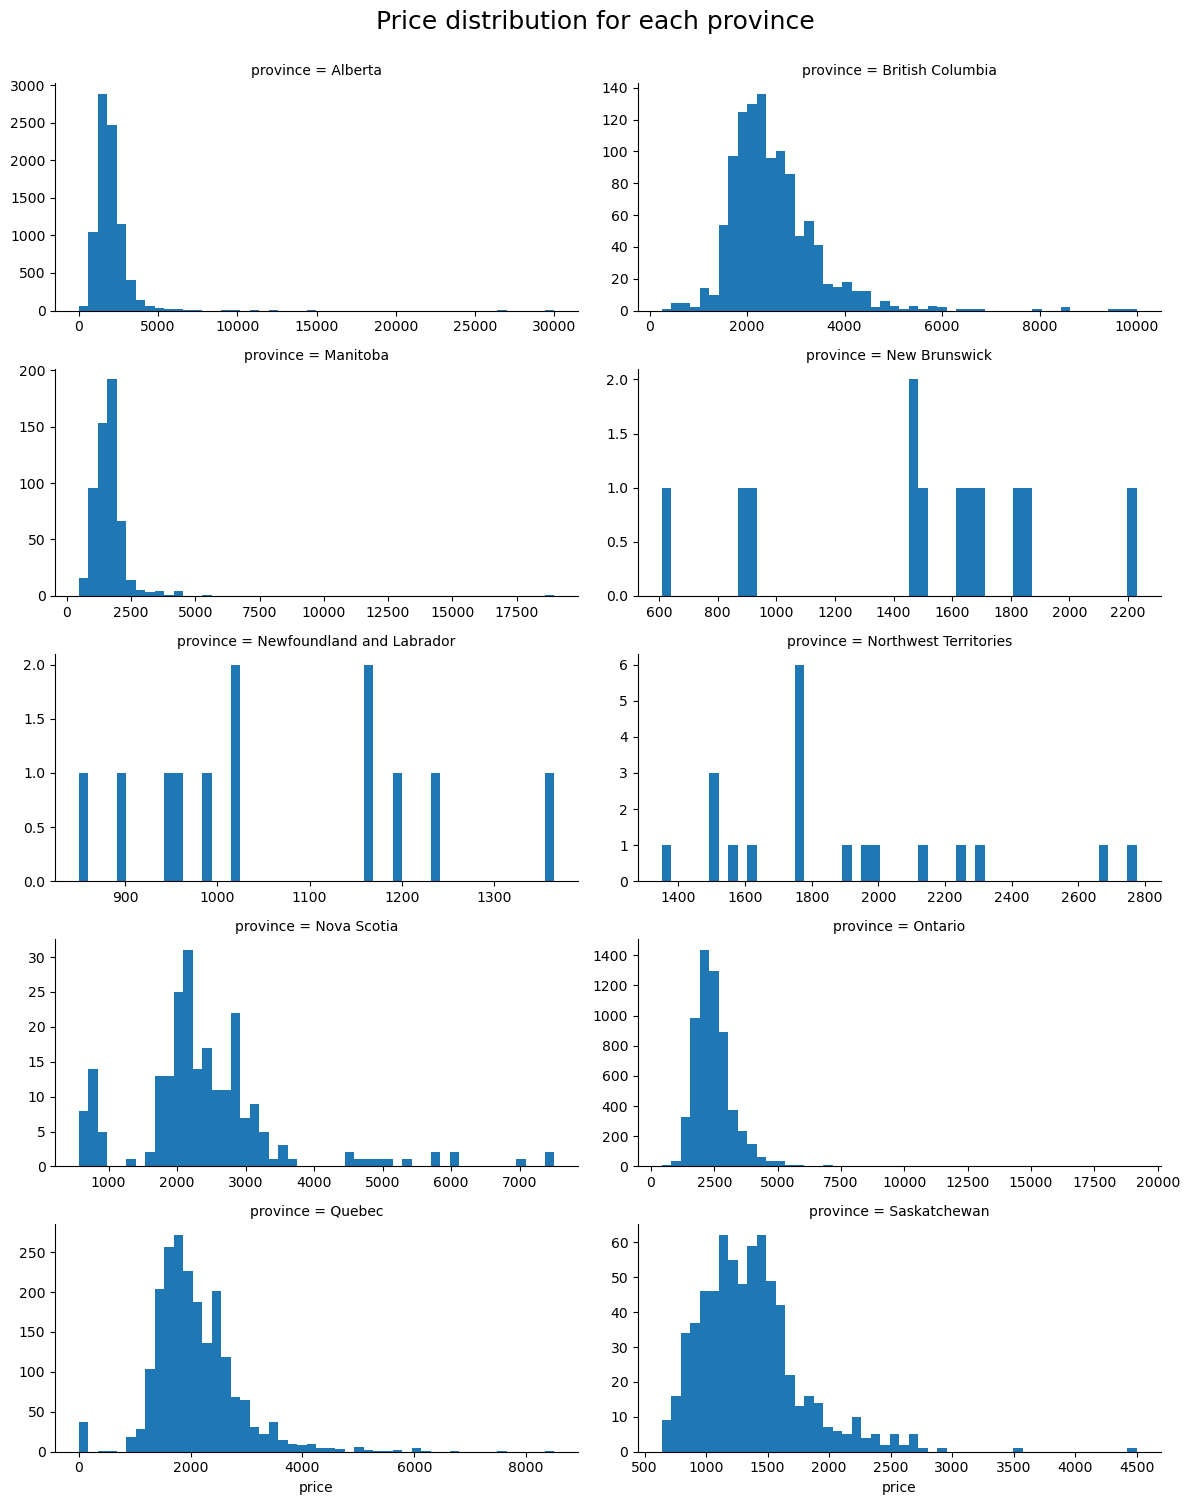

In [67]:
# Plot price distribution by province
g = sns.FacetGrid(data=df, col='province', col_wrap=2, sharex=False, sharey=False, aspect=2)
g.map(plt.hist, 'price', bins=50)
g.fig.suptitle('Price distribution for each province', fontsize=18, y=1)
g.fig.tight_layout();

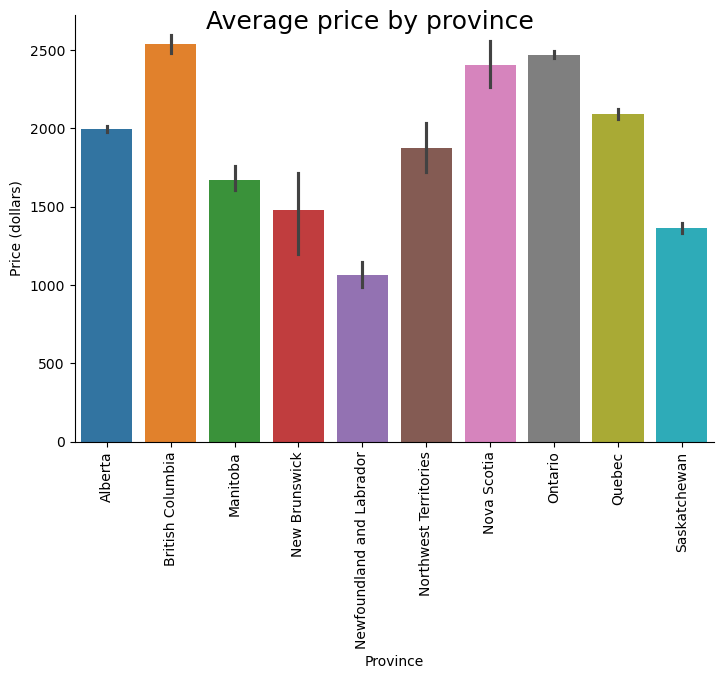

In [68]:
# Plot average price by province
ax = sns.catplot(data=df, x='province', y='price', kind='bar', aspect=1.5, hue='province')
ax.tick_params(axis='x', rotation=90)
ax.fig.suptitle('Average price by province', fontsize=18)
ax.set_xlabels('Province')
ax.set_ylabels('Price (dollars)');

In [69]:
# Get the 5 cities with the most Rentfaster ads
cities_list = list(df['city'].value_counts().head(5).index)
cities_list

['Calgary', 'Edmonton', 'Toronto', 'Montréal', 'Ottawa']

In [70]:
top_cities = df[df['city'].isin(cities_list)]
top_cities.shape

(12261, 18)

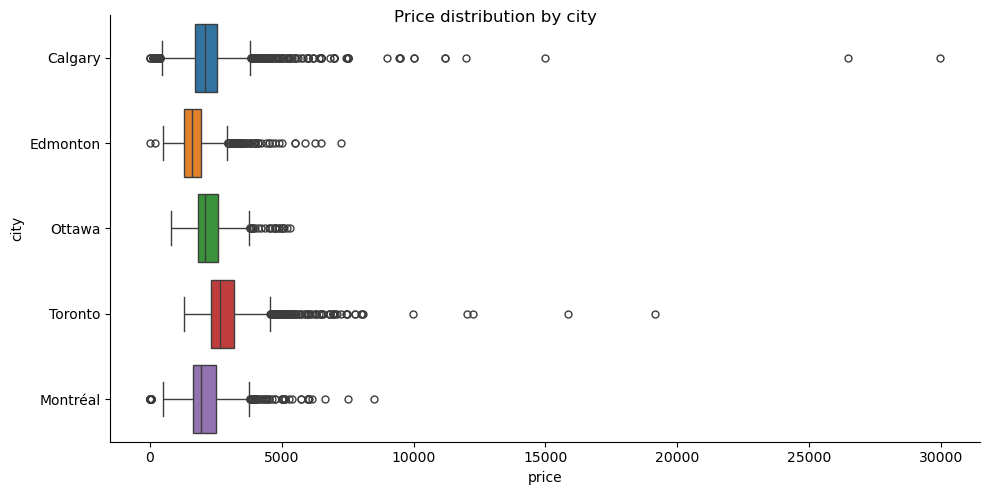

In [71]:
# Plot price distribution by the 5 top cities
g = sns.catplot(kind='box', data=top_cities, x='price', y='city', hue='city', aspect=2);
g.fig.suptitle('Price distribution by city');

There a lot of outliers when we look at the price distribution by city or province. This can have an impact on the performance of a machine learning model. 

---

## 4. Analyse outliers

In [75]:
# Detect outliers for Montreal with the Inter Quantile Range (IQR) approach
dist = montreal['price'].describe()

Q1 = dist['25%']
Q3 = dist['75%']
IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

montreal_outliers = montreal[(montreal['price'] < lower) | (montreal['price'] > upper)]
montreal_outliers.sort_values(by='price')

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
17421,566479,Montréal,Quebec,5460 Sherbrooke E,45.570721,-73.550125,Long Term,Apartment,1.0,0,1.0,2130.000000,/qc/montreal/rentals/apartment/studio/566479,Unfurnished,Immediate,Unknown,False,False
17382,552069,Montréal,Quebec,9250 avenue du Parc,45.537940,-73.654387,Long Term,Office Space,15.0,0,1.0,1936.000000,/qc/montreal/rentals/office-space/studio/552069,Unfurnished,Immediate,Unknown,True,True
17381,552069,Montréal,Quebec,9250 avenue du Parc,45.537940,-73.654387,Long Term,Office Space,15.0,0,1.0,6130.000000,/qc/montreal/rentals/office-space/studio/552069,Unfurnished,Immediate,Unknown,True,True
17379,552069,Montréal,Quebec,9250 avenue du Parc,45.537940,-73.654387,Long Term,Office Space,15.0,0,1.0,2204.000000,/qc/montreal/rentals/office-space/studio/552069,Unfurnished,Immediate,Unknown,True,True
17380,552069,Montréal,Quebec,9250 avenue du Parc,45.537940,-73.654387,Long Term,Office Space,15.0,0,1.0,10154.000000,/qc/montreal/rentals/office-space/studio/552069,Unfurnished,Immediate,Unknown,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16559,564523,Montréal,Quebec,450 rue Saint-François-Xavier,45.508326,-73.553580,Long Term,Apartment,6020.0,3,2.5,1371.060606,/qc/montreal/rentals/apartment/1-bedroom/pet-f...,Unfurnished,Immediate,Unknown,True,True
17698,505693,Montréal,Quebec,180 Rue de Bleury,45.505835,-73.565956,Short Term,Apartment,6150.0,2,2.0,739.000000,/qc/montreal/rentals/apartment/1-bedroom/pet-f...,Furnished,Immediate,Non-Smoking,True,True
18001,482392,Montréal,Quebec,275 Rue Saint-Jacques,45.502941,-73.559484,Long Term,Apartment,6650.0,0,1.0,2275.000000,/qc/montreal/rentals/apartment/studio/furnishe...,Furnished,July 01,Non-Smoking,False,False
16653,489209,Montréal,Quebec,3410 Peel Street,45.501915,-73.577106,Long Term,Apartment,7500.0,3,3.5,1778.000000,/qc/montreal/rentals/apartment/1-bedroom/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True


The higher prices come from rentals in more upscale neighbourhoods, whereas the lower price are office spaces. Perhaps it's a good idea to analyze the data by neighbourhood and by type of rental.

In [77]:
# Load data with postal codes
df = pd.read_csv('Data/data_with_postal_code.csv')
df.shape

(18947, 19)

In [78]:
# Get highest prices in Montreal
montreal = df[df['city'] == 'Montréal']
montreal.nlargest(n=5, columns='price')[['address', 'postal_code', 'type', 'sq_feet', 'lease_term', 'price']]

,address,postal_code,type,sq_feet,lease_term,price
16650,3410 Peel Street,H3A,Apartment,2000.000000,Long Term,8500.0
16653,3410 Peel Street,H3A,Apartment,1778.000000,Long Term,7500.0
18001,275 Rue Saint-Jacques,H2Y,Apartment,2275.000000,Long Term,6650.0
17698,180 Rue de Bleury,H3B,Apartment,739.000000,Short Term,6150.0
16559,450 rue Saint-François-Xavier,H2Y,Apartment,1371.060606,Long Term,6020.0


In [79]:
# Get lowest prices in Montreal
montreal = df[df['city'] == 'Montréal']
montreal.nsmallest(n=5, columns='price')[['address', 'postal_code', 'type', 'sq_feet', 'lease_term', 'price']]

,address,postal_code,type,sq_feet,lease_term,price
17421,5460 Sherbrooke E,H1N,Apartment,2130.0,Long Term,1.0
17373,9250 avenue du Parc,H2N,Office Space,3066.0,Long Term,15.0
17374,9250 avenue du Parc,H2N,Office Space,1776.0,Long Term,15.0
17375,9250 avenue du Parc,H2N,Office Space,1434.0,Long Term,15.0
17376,9250 avenue du Parc,H2N,Office Space,1699.0,Long Term,15.0


The highest prices come from apartments in Downtown and Old Montreal, which are neighbourhoods known to be expensice. The lowest prices come from office spaces, except one. The one with the 1$ price seems to be an outlier. This shows that analyzing with the province is not enough, not even the city. The neighbourhood and the type of rental are two important factors.

In [81]:
# Group data by postal code and type of rental and get distribution
price_by_pc_and_type = df.groupby(['postal_code', 'type'], observed=True).agg({'price': ['min', q1, 'median', 'mean', q3, 'max']})
price_by_pc_and_type.columns = price_by_pc_and_type.columns.get_level_values(1)
price_by_pc_and_type.sample(5)

,,min,q1,median,mean,q3,max
postal_code,type,,,,,,
R0E,Apartment,950.0,991.25,1032.5,1032.500000,1073.75,1115.0
K2K,Townhouse,2900.0,2900.00,2900.0,2900.000000,2900.00,2900.0
T2N,Main Floor,1900.0,2046.25,2322.5,2348.750000,2625.00,2850.0
N0H,Apartment,1674.0,1752.00,1850.0,1904.714286,2047.50,2210.0
J9H,Apartment,1250.0,1775.00,1877.5,1983.214286,2185.00,2800.0


In [82]:
# Filter out outliers by neibourhood and type
outliers = []

for (postal_code, type), row in price_by_pc_and_type.iterrows():
    IQR = row['q3'] - row['q1']
    lower = row['q1'] - 1.5*IQR
    upper = row['q3'] + 1.5*IQR
    new_df = df[(df['city'] == postal_code) & (df['type'] == type)]
    outliers += list(new_df[(new_df['price'] < lower) | (new_df['price'] > upper)].index)

In [83]:
# Print outliers
outliers.sort()
outliers_df = df.iloc[outliers]
outliers_df = outliers_df.sort_values(by=['province','city', 'type', 'price'])[['address', 'postal_code', 'type', 'sq_feet', 'lease_term', 'price']]
len(outliers_df)

0

In [84]:
# Remove rows with null postal codes
df = df.dropna(subset='postal_code')
df.shape

(18922, 19)

In [85]:
# Remove rows if there's only one occuence of postal code
is_multi = df['postal_code'].value_counts() > 1
df = df[df['postal_code'].isin(is_multi[is_multi].index)].reset_index(drop=True)
df.shape

(18832, 19)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18832 entries, 0 to 18831
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      18832 non-null  int64  
 1   city               18832 non-null  object 
 2   province           18832 non-null  object 
 3   address            18717 non-null  object 
 4   latitude           18832 non-null  float64
 5   longitude          18832 non-null  float64
 6   lease_term         18832 non-null  object 
 7   type               18832 non-null  object 
 8   price              18832 non-null  float64
 9   beds               18832 non-null  int64  
 10  baths              18832 non-null  float64
 11  sq_feet            18832 non-null  float64
 12  link               18832 non-null  object 
 13  furnishing         18832 non-null  object 
 14  availability_date  18824 non-null  object 
 15  smoking            18832 non-null  object 
 16  cats               188

In [87]:
# Dump cleaned data
df.to_csv('Data/cleaned_data.csv', index=False)

## End